# TTT4185 Machine learning for Speech technology

## Computer assigment 3b:  Regression analysis

Regression analysis is used to estimate/measure the relationship between an _independent_ variable, say $x$, and a _dependent_ variable, say $y$. One of the simplest regression problems is 
\begin{equation}
y = ax + b
\end{equation}
where $a$ and $b$ are constants. In practice our observations will be contaminated by noise, so we have
\begin{equation}
y = ax + b + n,
\end{equation}
where $n$ is noise, eg. measurement errors. This particular problem is called _linear regression_.

We will have a look at _non-linear regression_, using deep neural networks. Here we are looking at general regression problems in the form 
\begin{equation}
y = f(x) + n.
\end{equation}

We generate our data according to the function $f(x) = x^2 + \cos(20x) \text{ sign}(x)$, obtaining a set of observations $\{(x_i,y_i)\}$.

Then we assume we do not know the underlying function and we try to recover and approximation of $f$ only using the observations $\{(x_i,y_i)\}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

2022-11-07 16:49:39.923335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


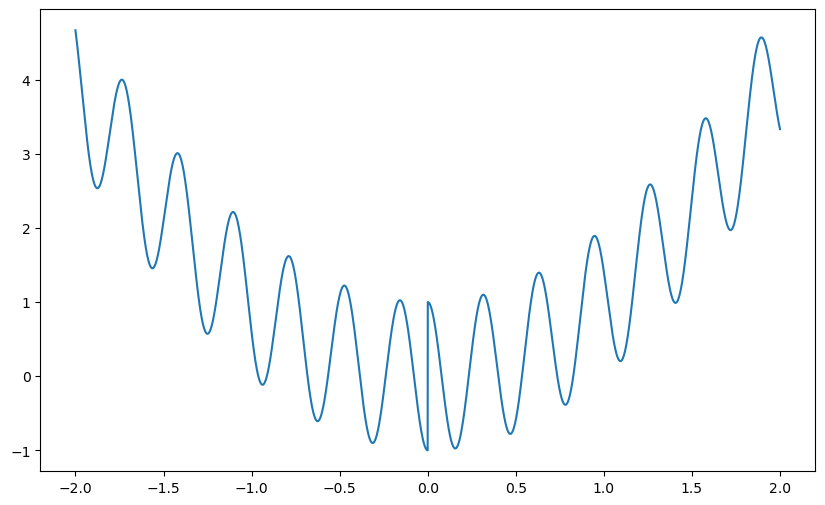

In [3]:
# Define function
def f(x):
    return x**2 + np.cos(20*x)*np.sign(x)

# Setup some simulation parameters
# Number of observations
N = 5000

# Plot a "clean" version of the relationship between x and y
plt.figure(figsize=(10, 6))
x = np.linspace(-2,2,N)
plt.plot(x,f(x))
plt.show()

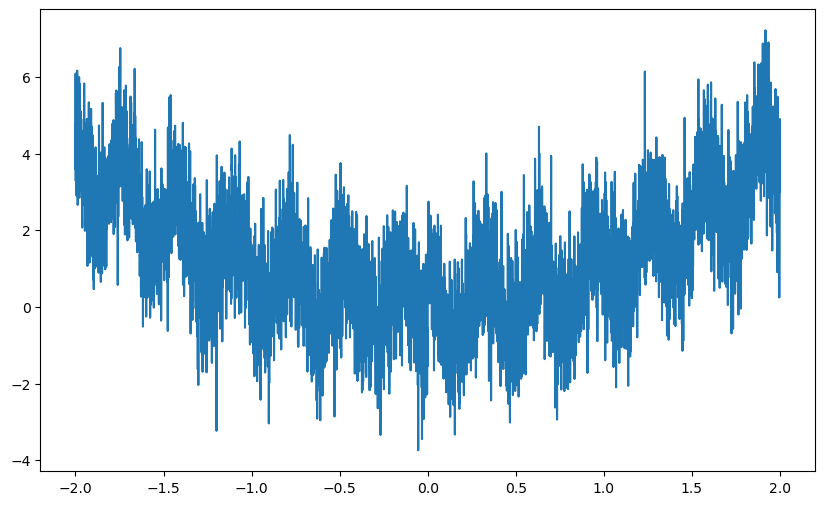

In [5]:
# Create a noise version of the observations
y = f(x) + np.random.randn(len(x))
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.show()

One way to perform regression is to assume that the data is generated using a set of functions from a cerain family, for example polynomials of order $p$,
\begin{equation}
\hat f(x) = a_0 + a_1 x + a_2 x^2 \ldots a_p x^p.
\end{equation}
Then regression corresponds to fitting the parameters in the model. Let us see how this works out before using our neural networks.

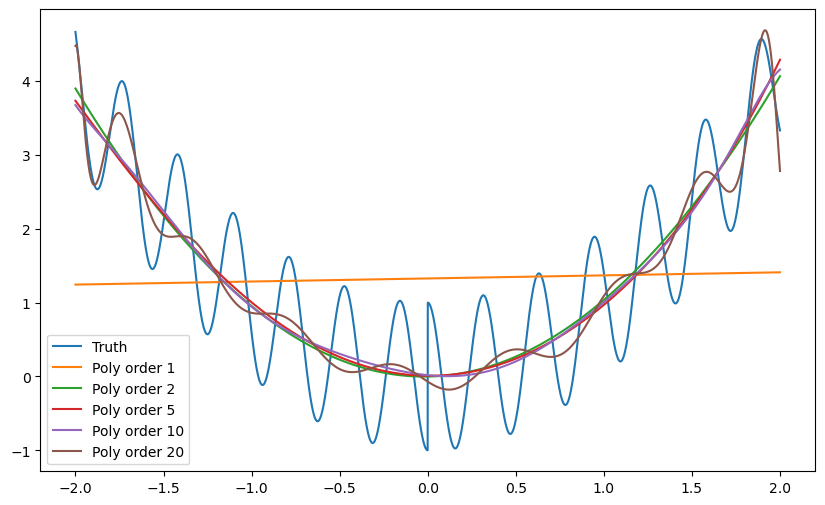

In [12]:
# Give a set of polynomial orders to try
P = [1, 2, 5, 10, 20]

# Define estimator function. Arguments are inout variable, observation and polynomial order
# Returns a set of polynomial coefficients
def reg_estimator(x,y,p):
    # Use simple ls approach
    N = len(x)
    H = np.zeros((N,p+1))
    for col in range(p+1):
        H[:,col] = x**col
    iHtH = np.linalg.inv(np.dot(H.T,H))
    theta = np.dot(np.dot(iHtH,H.T),y)
    return theta

# Computes fx) = c_0 + c_1x + c_2 x^2 ... c_p x^p
def poly(x, C):
    # compute p(x) for coeffs in c
    y = 0*x
    for p, c in enumerate(C):
        y += c*x**p        
    return y

plt.figure(figsize=(10,6))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

## Problem 1
Play with different $p$ to see how close you can get to the true function.

Note: Very high $p$ will give numerical problems.

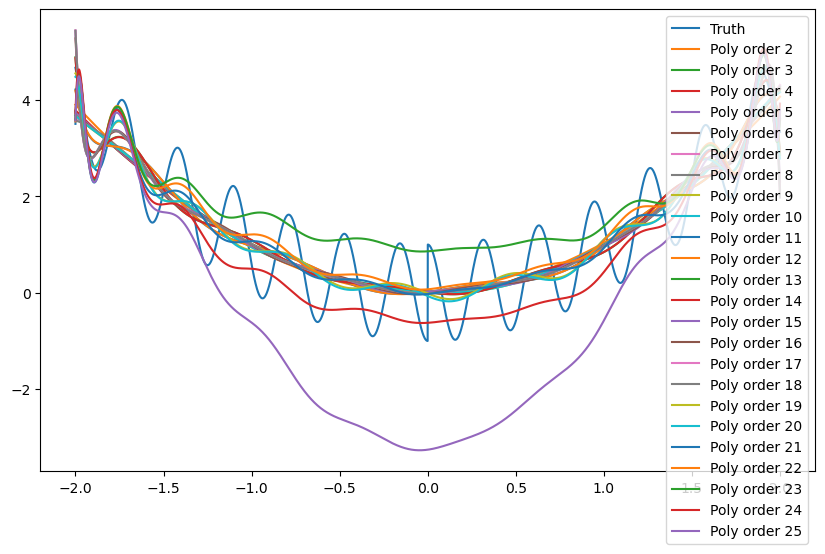

In [24]:
# Give a set of polynomial orders to try
P = list(range(2, 26))

# Define estimator function. Arguments are inout variable, observation and polynomial order
# Returns a set of polynomial coefficients
def reg_estimator(x,y,p):
    # Use simple ls approach
    N = len(x)
    H = np.zeros((N,p+1))
    for col in range(p+1):
        H[:,col] = x**col
    iHtH = np.linalg.inv(np.dot(H.T,H))
    theta = np.dot(np.dot(iHtH,H.T),y)
    return theta

# Computes fx) = c_0 + c_1x + c_2 x^2 ... c_p x^p
def poly(x, C):
    # compute p(x) for coeffs in c
    y = 0*x
    for p, c in enumerate(C):
        y += c*x**p        
    return y

plt.figure(figsize=(10,6))
plt.plot(x,f(x),label="Truth")
for p in P:
    C = reg_estimator(x,y,p)
    plt.plot(x,poly(x,C),label="Poly order " + str(p))
plt.legend()
plt.show()

In what follows we will use a deep neural network to approximate $f$. We set this up below

In [25]:
# Ceate a model with a single hidden layer. Note that input and output has
# dimension one
M = 512
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(1)
])

model.summary()
# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

2022-11-07 16:55:23.996084: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-07 16:55:24.007473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-07 16:55:24.301949: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-07 16:55:24.302090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-11-07 16:55:24.302151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-07 16:55:24.313242: I tensorflow/stream_executor/plat

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


We train the network by using $x$ as an input and the squared error between the network output $\hat y$ and the observed value $y$ as a loss
\begin{equation}
 L = \frac{1}{N} \sum_n (\hat y - y)^2
\end{equation}

We first try our network on clean data to check if it works.

In [27]:
# train the model
history = model.fit(x, f(x), epochs=100, batch_size=128, verbose=True)

Epoch 1/100
40/40 [==============================] - 0s 7ms/step - loss: 0.4922 - accuracy: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4933 - accuracy: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4922 - accuracy: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4960 - accuracy: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 0s 7ms/step - loss: 0.4943 - accuracy: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4923 - accuracy: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4907 - accuracy: 0.0000e+00
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4938 - accuracy: 0.0000e+00
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 0.4929 - accuracy: 0.0000e+00
Epoch 10/100
40/40 [==============================] - 0s 5ms/step - loss:

Using the variable `history`, plot the evolution of the loss during training. 

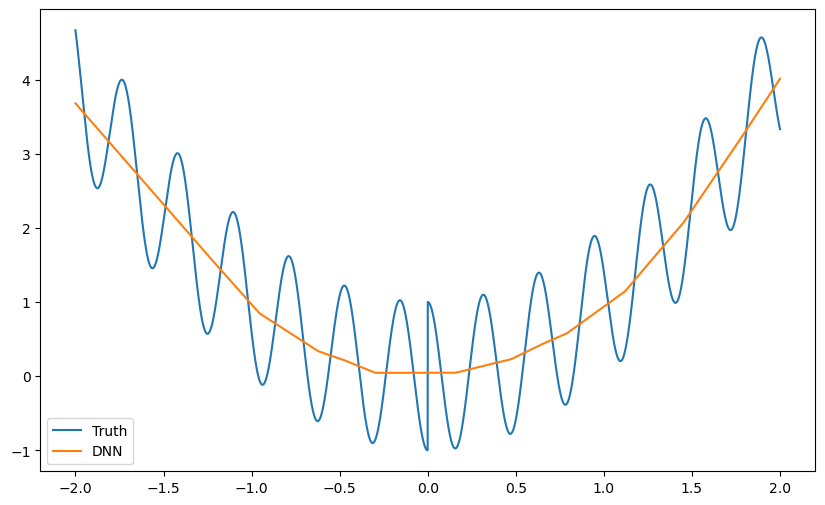

In [29]:
# Compute \hat y from the network and compare this to the true f(x)
z = model.predict(x)
plt.figure(figsize=(10,6))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 2
Try increasing the number of nodes in the network to see if the results can be improved.

In [35]:
Ms = [512, 1024, 2048, 4096]
models = []

for M in Ms:
    model = keras.Sequential([
        keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
        keras.layers.Dense(1)
    ])

    # Train the model
    model.compile(loss='mean_squared_error',
                optimizer="adam",
                metrics=['accuracy'])

    history = model.fit(x, f(x), epochs=20, batch_size=128, verbose=True)

    models.append(model)


Epoch 1/20
40/40 [==============================] - 1s 8ms/step - loss: 2.4397 - accuracy: 0.0000e+00
Epoch 2/20
40/40 [==============================] - 0s 6ms/step - loss: 0.9091 - accuracy: 0.0000e+00
Epoch 3/20
40/40 [==============================] - 0s 6ms/step - loss: 0.7322 - accuracy: 0.0000e+00
Epoch 4/20
40/40 [==============================] - 0s 5ms/step - loss: 0.6372 - accuracy: 0.0000e+00
Epoch 5/20
40/40 [==============================] - 0s 4ms/step - loss: 0.5883 - accuracy: 0.0000e+00
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.5570 - accuracy: 0.0000e+00
Epoch 7/20
40/40 [==============================] - 0s 6ms/step - loss: 0.5497 - accuracy: 0.0000e+00
Epoch 8/20
40/40 [==============================] - 0s 6ms/step - loss: 0.5253 - accuracy: 0.0000e+00
Epoch 9/20
40/40 [==============================] - 0s 5ms/step - loss: 0.5243 - accuracy: 0.0000e+00
Epoch 10/20
40/40 [==============================] - 0s 6ms/step - loss: 0.5176 - 

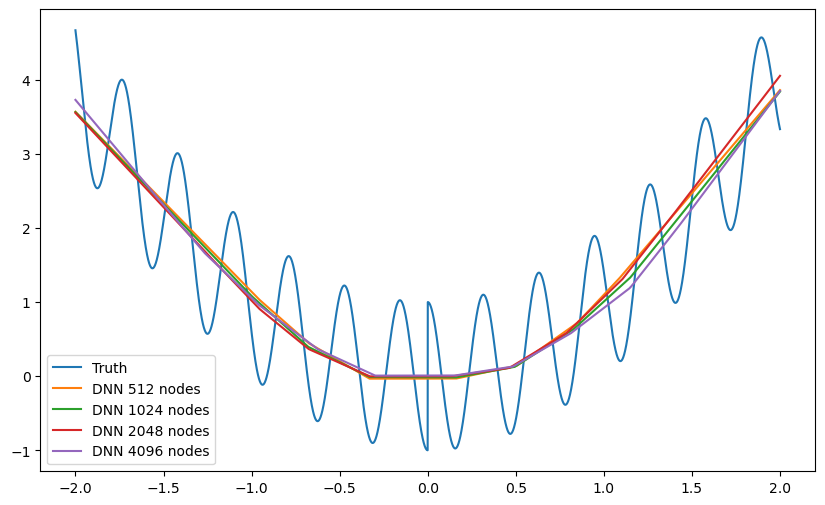

In [36]:
# Compute \hat y from the network and compare this to the true f(x)
plt.figure(figsize=(10,6))
plt.plot(x,f(x),label="Truth")
for i, model in enumerate(models):
    z = model.predict(x)
    plt.plot(x,z, label=f"DNN {Ms[i]} nodes")
plt.legend()
plt.show()

Next we will use a deep network with more than one hidden layer.

In [33]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 16
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x), epochs=100, batch_size=128, verbose=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 1s 7ms/step - loss: 3.0037 - accuracy: 0.0000e+00
Epoch 2/100
40/40 [

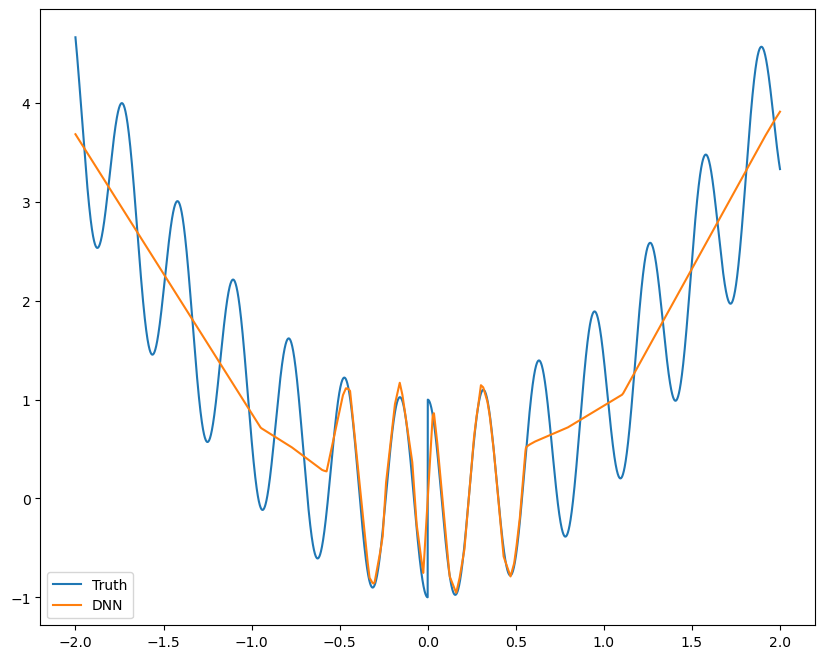

In [34]:
z = model.predict(x)
plt.figure(figsize=(10,8))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()

## Problem 3
Try increasing the number of hidden nodes per layer until performance is satisfactory. Can the same effect be achieved by just adding more layers?

In [42]:
models = []
Ms = [16, 32, 64, 128]

for M in Ms:
    model = keras.Sequential([
        keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
        keras.layers.Dense(M, activation=tf.nn.relu),
        keras.layers.Dense(M, activation=tf.nn.relu),
        keras.layers.Dense(M, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    # Train the model
    model.compile(loss='mean_squared_error',
                optimizer="adam",
                metrics=['accuracy'])

    history = model.fit(x, f(x), epochs=500, batch_size=128, verbose=True)

    models.append(model)

Epoch 1/500
40/40 [==============================] - 1s 9ms/step - loss: 3.4167 - accuracy: 0.0000e+00
Epoch 2/500
40/40 [==============================] - 0s 6ms/step - loss: 2.2904 - accuracy: 0.0000e+00
Epoch 3/500
40/40 [==============================] - 0s 6ms/step - loss: 1.1892 - accuracy: 0.0000e+00
Epoch 4/500
40/40 [==============================] - 0s 6ms/step - loss: 0.9494 - accuracy: 0.0000e+00
Epoch 5/500
40/40 [==============================] - 0s 6ms/step - loss: 0.8057 - accuracy: 0.0000e+00
Epoch 6/500
40/40 [==============================] - 0s 6ms/step - loss: 0.6633 - accuracy: 0.0000e+00
Epoch 7/500
40/40 [==============================] - 0s 6ms/step - loss: 0.5751 - accuracy: 0.0000e+00
Epoch 8/500
40/40 [==============================] - 0s 6ms/step - loss: 0.5303 - accuracy: 0.0000e+00
Epoch 9/500
40/40 [==============================] - 0s 7ms/step - loss: 0.5177 - accuracy: 0.0000e+00
Epoch 10/500
40/40 [==============================] - 0s 7ms/step - loss:

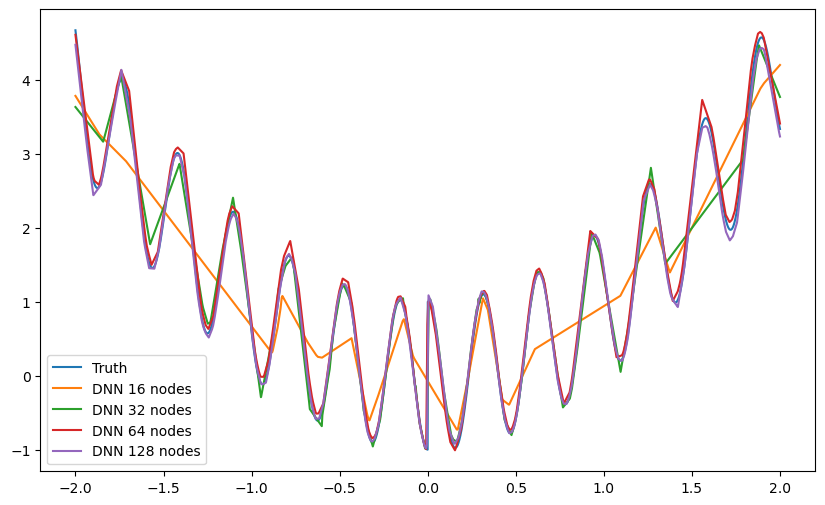

In [43]:
plt.figure(figsize=(10,6))
plt.plot(x,f(x),label="Truth")
for i, model in enumerate(models):
    z = model.predict(x)
    plt.plot(x,z, label=f"DNN {Ms[i]} nodes")
plt.legend()
plt.show()

## Problem 4
Using the best setup from the previous problem, train a model using the noisy data.

In [46]:
# Create a model with multiple hidden layers. Note that input and output has
# dimension one
M = 64
model = keras.Sequential([
    keras.layers.Dense(M, activation=tf.nn.relu, input_dim=1),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(M, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
model.summary()

# Train the model
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(x, f(x) + np.random.randn(len(x)), epochs=500, batch_size=128, verbose=True)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_100 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_101 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_102 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 65        
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
40/40 [==============================] - 1s 10ms/step - loss: 3.2162 - accuracy: 0.0000e+00
Epoch 2/500

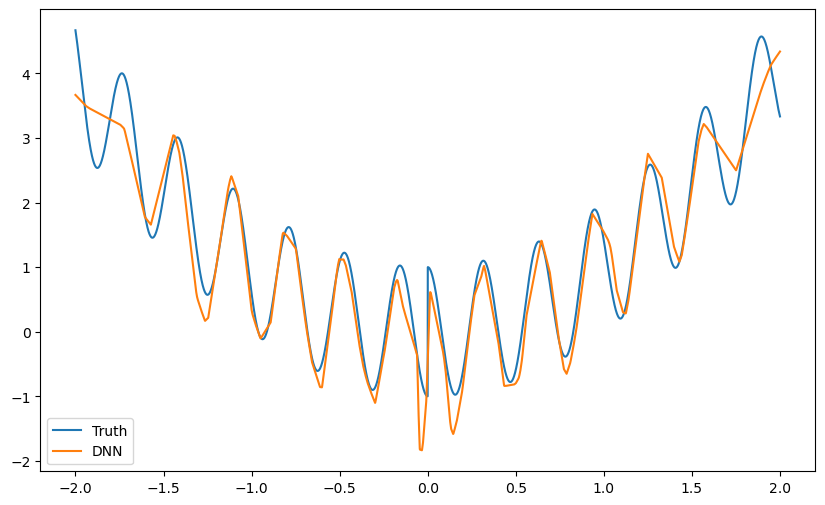

In [48]:
z = model.predict(x)
plt.figure(figsize=(10,6))
plt.plot(x,f(x),label="Truth")
plt.plot(x,z,label="DNN")
plt.legend()
plt.show()